In [209]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from lyap_obj import *

In [210]:
def Poinc_hit(t, S, T, mu):
    # Assuming that the Poincare section is a plane, we can find the intersection
    # of the trajectory with the plane by solving for the intersection point.
    # We can then use the intersection point to find the intersection of the
    # trajectory with the Poincare section.

    # Assuming Poinc_sect  x = 1-mu
    return not(abs(S[0] - (1 - mu)) < 1e-3)
    

Poinc_hit.terminal = True

In [211]:
def compute_manifold(orbit: LyapOrbit, n_curves = 10, verbose = False, k = 1, 
                     terminal = True):

    # Computes the stable and unstable manifolds of a given orbit

    # k: tau_f = k*T, where tau_f is the final time of the integration
    if k < 0 or k == 0:
        raise ValueError("k must be a positive real number")
    
    # Perturbation parameter
    de = 40/384400

    # Compute the periodic orbit
    X, PHI = orbit.propagate()

    # Compute the length of the orbit
    length = len(X[0,:])
    
    T = orbit.Yd[2]
    mu = orbit.mu
    sols_s = []
    sols_u = []

    p = X[:, -1]
    ### Compute the eigs (Es, Eu)[0] and eigenvectors (EVs, EVu) of the STM
    M = PHI[:,:,-1] # Monodromy matrix (PHI(T,0))
    eigvals, eigvecs = splin.eig(M)

    # Compute the stable and unstable eigenvectors
    # E is stable if Re(eigval) < 1 and unstable if Re(eigval) > 1
    # We also need to take into account that the eigenvalues are complex, 
    # we need only the real ones tho
    
    Es_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) < 1 and eigvals[i].imag == 0]
    Eu_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) > 1 and eigvals[i].imag == 0]

    Es0, Eu0 = eigvals[Es_idx], eigvals[Eu_idx]
    EVs0, EVu0 = eigvecs[:, Es_idx], eigvecs[:, Eu_idx]
    if verbose:
        print(f"Stable eigenvalues: {Es0}")
        print(f"Unstable eigenvalues: {Eu0}")

        print(f"Stable eigenvectors: {EVs0}")
        print(f"Unstable eigenvectors: {EVu0}")


    for i in range(n_curves):
        # We now need to choose some point on the periodic orbit. We also need
        # to take into account that M is the STM starting from the current choosen point
        # and then propagated for one period. Hence, we could choose the point and then
        # propagate it or employ the formula
        # Es(tau) = PHI(tau,0) * Es(0)
        # Eu(tau) = PHI(tau,0) * Eu(0)
        # for a point temporally distant tau from the initial point.
        if i == 0:
            # Initial case, we already have computed the eigenvectors needed
            EVs = EVs0
            EVu = EVu0
    
        else:
            # We need to recompute p, the associated eigenvectors and eigenvalues
            # idx moves the point on the periodic orbit by displacing it in time
            idx = i*length//n_curves
            p = X[:,idx]
            PHI_p = PHI[:,:,idx]

            EVs = PHI_p @ EVs0
            EVu = PHI_p @ EVu0

            if verbose:
                print(f"Stable eigenvectors at point {i}: {EVs}")
                print(f"Unstable eigenvectors at point {i}: {EVu}")
  
        # Only real part is needed, the imaginary part is due to casting to complex and 0
        # Stable 
        X_s_p = np.real(p + de*EVs[:,0]/np.linalg.norm(EVs[:2,0]))
        X_s_m = np.real(p - de*EVs[:,0]/np.linalg.norm(EVs[:2,0]))
        # Unstable
        X_u_p = np.real(p + de*EVu[:,0]/np.linalg.norm(EVu[:2,0]))
        X_u_m = np.real(p - de*EVu[:,0]/np.linalg.norm(EVu[:2,0]))
        
        ### Propagate the deviation vectors
        # Build the initial conditions
        PHI0 = np.eye(4)
        X0sp = np.concatenate((X_s_p, PHI0.flatten()))
        X0sm = np.concatenate((X_s_m, PHI0.flatten()))
        X0up = np.concatenate((X_u_p, PHI0.flatten()))
        X0um = np.concatenate((X_u_m, PHI0.flatten()))
        
        
        if verbose:
            print(f"Initial conditions for stable manifold: {X0sp}")
            print(f"Initial conditions for unstable manifold: {X0up}")


        # Stable (backwards)
        if terminal:
            # Terminal event set

            # Stable (backward)
            sol_sp = solve_ivp(fdyn, [0, -k*T], X0sp, 
                                args = (T,mu), method='LSODA', 
                                events=Poinc_hit, 
                                rtol=3e-12, atol=1e-12)
            
            sol_sm = solve_ivp(fdyn, [0, -k*T], X0sm, 
                                args = (T,mu), method='LSODA',
                                events=Poinc_hit, 
                                rtol=3e-12, atol=1e-12)
            # Unstable (forward)
            sol_up = solve_ivp(fdyn, [0, k*T], X0up,
                                args = (T,mu), method='LSODA',
                                events=Poinc_hit, 
                                rtol=3e-12, atol=1e-12)
            sol_um = solve_ivp(fdyn, [0, k*T], X0um, 
                                args = (T,mu), method='LSODA',
                                events=Poinc_hit, 
                                rtol=3e-12, atol=1e-12)
            
        else:
            # Stable (backward)
            sol_sp = solve_ivp(fdyn, [0, -k*T], X0sp, 
                                args = (T,mu), method='LSODA', 
                                rtol=3e-12, atol=1e-12)
            
            sol_sm = solve_ivp(fdyn, [0, -k*T], X0sm, 
                                args = (T,mu), method='LSODA',
                                rtol=3e-12, atol=1e-12)

            # Unstable (forward)
            sol_up = solve_ivp(fdyn, [0, k*T], X0up,
                                args = (T,mu), method='LSODA',
                                rtol=3e-12, atol=1e-12)
            sol_um = solve_ivp(fdyn, [0, k*T], X0um, 
                                args = (T,mu), method='LSODA',
                                rtol=3e-12, atol=1e-12)
   
        # Extract the solution
        Xsp = sol_sp.y[:4,:]
        Xsm = sol_sm.y[:4,:]
        Xup = sol_up.y[:4,:]
        Xum = sol_um.y[:4,:]

        # Stable and unstable tuple
        # return of the integration process
        ret = (Xsp, Xsm), (Xup, Xum)


        # Append the solution to the list
        sols_s.append(ret[0])
        sols_u.append(ret[1])

        print(f"\rCurve {i+1}/{n_curves} computed")
    # End of loop

    
    return sols_s, sols_u

In [212]:
# Load orbits from file
L1_0 = load_orbit("out/L1_0.npz")
L1_1 = load_orbit("out/L1_1.npz")

L2_0 = load_orbit("out/L2_0.npz")
L2_1 = load_orbit("out/L2_1.npz")

L1_orbits = [L1_0, L1_1]
L2_orbits = [L2_0, L2_1]

In [213]:
solss_s, solss_u = compute_manifold(L1_0, n_curves=500, k = 1)

Curve 1/500 computed
Curve 2/500 computed
Curve 3/500 computed
Curve 4/500 computed
Curve 5/500 computed
Curve 6/500 computed
Curve 7/500 computed
Curve 8/500 computed
Curve 9/500 computed
Curve 10/500 computed
Curve 11/500 computed
Curve 12/500 computed
Curve 13/500 computed
Curve 14/500 computed
Curve 15/500 computed
Curve 16/500 computed
Curve 17/500 computed
Curve 18/500 computed
Curve 19/500 computed
Curve 20/500 computed
Curve 21/500 computed
Curve 22/500 computed
Curve 23/500 computed
Curve 24/500 computed
Curve 25/500 computed
Curve 26/500 computed
Curve 27/500 computed
Curve 28/500 computed
Curve 29/500 computed
Curve 30/500 computed
Curve 31/500 computed
Curve 32/500 computed
Curve 33/500 computed
Curve 34/500 computed
Curve 35/500 computed
Curve 36/500 computed
Curve 37/500 computed
Curve 38/500 computed
Curve 39/500 computed
Curve 40/500 computed
Curve 41/500 computed
Curve 42/500 computed
Curve 43/500 computed
Curve 44/500 computed
Curve 45/500 computed
Curve 46/500 comput

In [214]:
mu = L1_1.mu


# Compute the zero velocity curve
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)

X, Y = np.meshgrid(x, y)

U_grid = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        U_grid[i,j] = U(np.array([x[i], y[j]]), mu) 




        

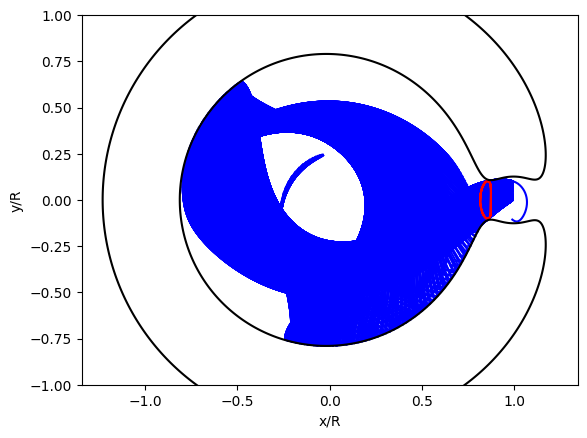

In [215]:
# Plot the stable and unstable manifolds 
Xly1, PHI = L1_0.propagate()

Cj = L1_0.C
mu = L1_0.mu

plt.figure()
for i in range(len(solss_s)):
    sols = solss_s[i]

    for sol in sols:
        # Fade curve 
        plt.plot(sol[0,:], sol[1,:], 'b')
        
plt.plot(Xly1[0,:], Xly1[1,:], 'r')
# Black contour
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("x/R")
plt.ylabel("y/R")
plt.show()

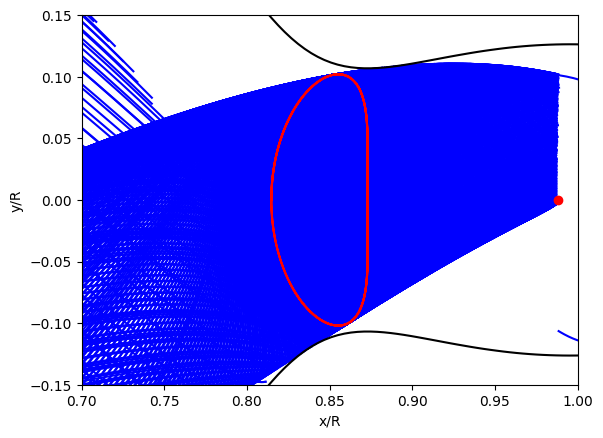

In [216]:
plt.figure()
for i in range(len(solss_s)):
    sols = solss_s[i]

    for sol in sols:
        plt.plot(sol[0,:], sol[1,:], 'b')



plt.plot(1-mu, 0, 'ro')
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')
plt.plot(Xly1[0,:], Xly1[1,:], 'r')
plt.xlim(0.7,1)
plt.ylim(-0.15,0.15)
plt.xlabel("x/R")
plt.ylabel("y/R")
plt.show()

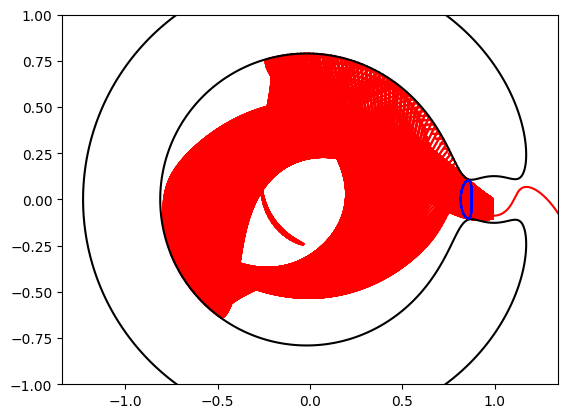

In [217]:
# Plot unstable manifold
plt.figure()
for i in range(len(solss_u)):
    sols = solss_u[i]
    for sol in sols:
        plt.plot(sol[0,:], sol[1,:], 'r', markersize = 0.1)
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')
plt.plot(Xly1[0,:], Xly1[1,:], 'b')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

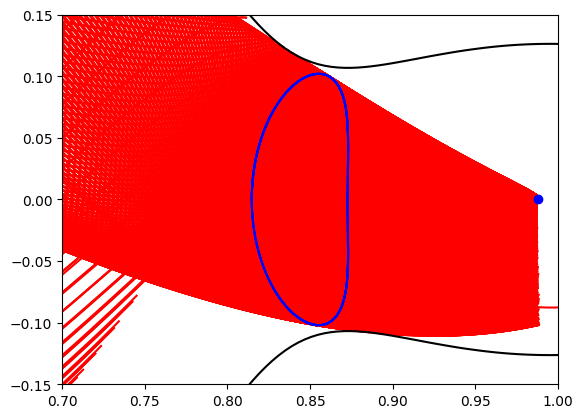

In [218]:
plt.figure()
for i in range(len(solss_u)):
    sols = solss_u[i]

    for sol in sols:
        plt.plot(sol[0,:], sol[1,:], 'r')

plt.plot(Xly1[0,:], Xly1[1,:], 'b')

plt.plot(1-mu, 0, 'bo')
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')
plt.xlim(0.7,1)
plt.ylim(-0.15,0.15)
plt.show()

In [219]:
# Do the same for an L2 orbit
solss_s2, solss_u2 = compute_manifold(L2_0, n_curves=500, k=1)

Curve 1/500 computed
Curve 2/500 computed
Curve 3/500 computed
Curve 4/500 computed
Curve 5/500 computed
Curve 6/500 computed
Curve 7/500 computed
Curve 8/500 computed
Curve 9/500 computed
Curve 10/500 computed
Curve 11/500 computed
Curve 12/500 computed
Curve 13/500 computed
Curve 14/500 computed
Curve 15/500 computed
Curve 16/500 computed
Curve 17/500 computed
Curve 18/500 computed
Curve 19/500 computed
Curve 20/500 computed
Curve 21/500 computed
Curve 22/500 computed
Curve 23/500 computed
Curve 24/500 computed
Curve 25/500 computed
Curve 26/500 computed
Curve 27/500 computed
Curve 28/500 computed
Curve 29/500 computed
Curve 30/500 computed
Curve 31/500 computed
Curve 32/500 computed
Curve 33/500 computed
Curve 34/500 computed
Curve 35/500 computed
Curve 36/500 computed
Curve 37/500 computed
Curve 38/500 computed
Curve 39/500 computed
Curve 40/500 computed
Curve 41/500 computed
Curve 42/500 computed
Curve 43/500 computed
Curve 44/500 computed
Curve 45/500 computed
Curve 46/500 comput

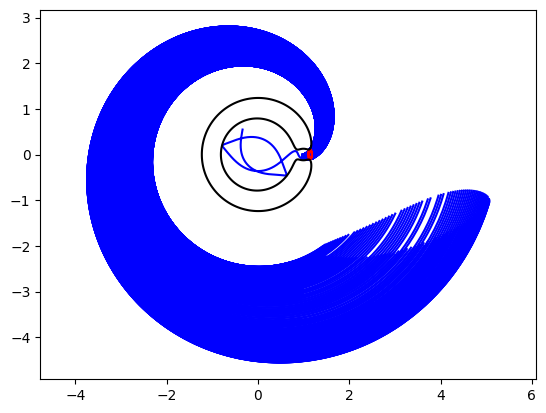

In [220]:
# Plot the stable and unstable manifolds 
Xly, PHI = L2_0.propagate()

Cj = L1_0.C
mu = L1_0.mu

plt.figure()
for i in range(len(solss_s2)):
    sols = solss_s2[i]

    for sol in sols:
        plt.plot(sol[0,:], sol[1,:], 'b')
plt.plot(Xly[0,:], Xly[1,:], 'r')
# Black contour
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')


plt.axis('equal')

plt.show()


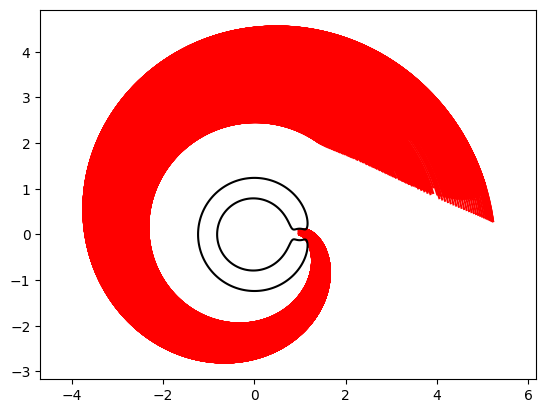

In [221]:
# Plot unstable manifold
plt.figure()
for i in range(len(solss_u2)):
    sols = solss_u2[i]
    for sol in sols:
        plt.plot(sol[0,:], sol[1,:], 'r')
plt.contour(Y, X, U_grid, levels = [Cj/2], colors = 'k')

plt.axis('equal')
plt.show()

In [222]:
Psect = np.array([1-mu, 0]) # Poincare section on the Moon

# Compute the intersection of the stable manifold with the Poincare section
# and plot it


In [223]:
# [X, M, E], investigate unstable LL2 and stable LL1
# Take the solution corresponding to all the manifolds of the stable LL1
stableLL1 = solss_s
unstableLL2 = solss_u2



In [224]:
# Find all solutins that intersect the Poincare section
stableLL1_P = []
for i in range(len(stableLL1)):
    sols = stableLL1[i]
    for sol in sols:
        for j in range(len(sol[0,:])):
            if np.linalg.norm(sol[0,j] - (1-mu)) < 1e-3 and sol[1,j] > 0:
                stableLL1_P.append(sol[:,j])
                break

In [225]:
# Find all solutins that intersect the Poincare section
# We need to discard diverging solutions, check on y
unstableLL2_P = []
for i in range(len(unstableLL2)):
    sols = unstableLL2[i]
    for sol in sols:
        for j in range(len(sol[0,:])):
            if np.linalg.norm(sol[0,j] - (1-mu)) < 1e-3:
                if np.abs(sol[1,j]) > 1:
                    continue
                unstableLL2_P.append(sol[:,j])
                break


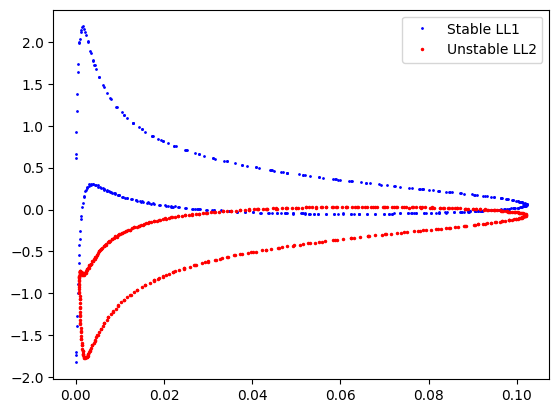

In [226]:
# Plot stable_LL1_P
stableLL1_P = np.array(stableLL1_P)
# Delete from stableLL1 the negative  values
unstableLL2_P = np.array(unstableLL2_P)

plt.figure()
plt.plot(stableLL1_P[:,1], stableLL1_P[:,3], 'bo', label = 'Stable LL1', markersize = 1)

plt.plot(unstableLL2_P[:,1], unstableLL2_P[:,3], 'ro', label = 'Unstable LL2', markersize = 1.5)
plt.legend()

plt.show()



In [227]:
# Find an y-v value such that it is inside the stable manifold of LL1 and the unstable manifold of LL2
C = L1_0.C
for i in range(len(stableLL1_P)):
    for j in range(len(unstableLL2_P)):
        if np.abs(stableLL1_P[i][1] - unstableLL2_P[j][1]) < 1e-5  and stableLL1_P[i][1] > 0.055 and stableLL1_P[i][1] < 0.1 \
        and unstableLL2_P[j][3] > stableLL1_P[i][3]:
            # Compute point in between
            point = np.zeros(4)
            point[0] = (1 - muEM)
            point[1] = stableLL1_P[i][1]
            point[3] = (unstableLL2_P[j][3] + stableLL1_P[i][3])/2
            
            U_ = U(point[:2], muEM)
            point[2] = np.sign(stableLL1_P[i][2])*np.sqrt(-(C - 2*U_ + point[3]**2))

In [228]:
# [X, M, E]
PHI0 = np.eye(4)
X0 = np.concatenate((point, PHI0.flatten()))
T = L1_0.Yd[2]

sol_xme_f = solve_ivp(fdyn, [0, T], X0, args = (T, muEM), method='LSODA', rtol=3e-12, atol=1e-12) # Forward
sol_xme_b = solve_ivp(fdyn, [0, -T], X0, args = (T, muEM), method='LSODA', rtol=3e-12, atol=1e-12) # Backward


In [229]:
# [E M X]
PHI0 = np.eye(4)
point_ym = np.array([point[0], -point[1], -point[2], point[3]])
X0 = np.concatenate((point_ym, PHI0.flatten()))
T = L1_0.Yd[2]

sol_emx_f = solve_ivp(fdyn, [0, T], X0, args = (T, muEM), method='LSODA', rtol=3e-12, atol=1e-12) # Forward
sol_emx_b = solve_ivp(fdyn, [0, -T], X0, args = (T, muEM), method='LSODA', rtol=3e-12, atol=1e-12) # Backward

In [230]:
print(point)

[ 0.98785527  0.0907749  -0.27358012 -0.00723702]


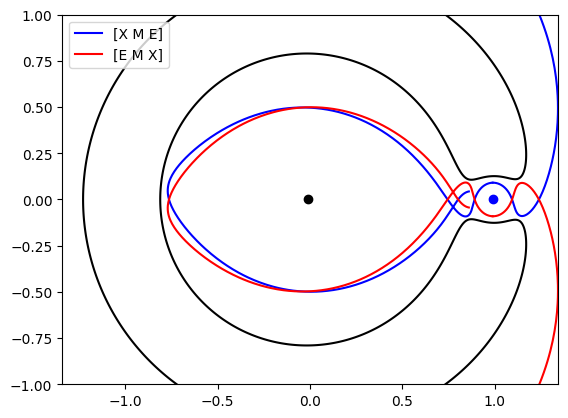

In [231]:
# Plot the solution
plt.figure()
plt.plot(sol_xme_f.y[0,:], sol_xme_f.y[1,:], 'b', label = "[X M E]") # Forward 
plt.plot(sol_xme_b.y[0,:], sol_xme_b.y[1,:], 'b') # Backwards 

plt.plot(sol_emx_f.y[0,:], sol_emx_f.y[1,:], 'r', label = "[E M X]") # Forward 
plt.plot(sol_emx_b.y[0,:], sol_emx_b.y[1,:], 'r') # Backwards 

plt.plot(1-muEM, 0, 'bo')   
plt.plot(-muEM, 0, 'ko')
plt.legend()
plt.axis('equal')
plt.contour(Y, X, U_grid, levels = [C/2], colors = 'k')
plt.xlim(-1,1)
plt.ylim(-1,1)


plt.show()